In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, math
from matplotlib.colors import hsv_to_rgb
from numba import cuda, jit, prange


In [2]:
@cuda.jit
def get_grid_cuda(Z,coef,lenCoef):
    i, j = cuda.grid(2)
    if i >=0 and i < Z.shape[0] and j >=0 and j < Z.shape[1]:     
        for _ in range(500):
            
            fx=0
            for _i in range(lenCoef):
                fx+=coef[_i]*Z[i,j]**(lenCoef-_i-1)

            dfx=0
            for _i in range(lenCoef-1):
                dfx+=coef[_i]*(lenCoef-_i-1)*Z[i,j]**(lenCoef-_i-2)

            
            # fx=Z[i,j]**3+Z[i,j]**2+Z[i,j]+1
            # dfx=3*Z[i,j]**2+2*Z[i,j]+1
            div=fx/dfx
            Z[i,j]=Z[i,j]-div
            if(abs(div)<1e-6):
                break

C:\Users\joejo\Miniconda3\lib\site-packages\numba\cuda\cudadrv\devicearray.py:790: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Time taken: 6.33372163772583


C:\Users\joejo\Miniconda3\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


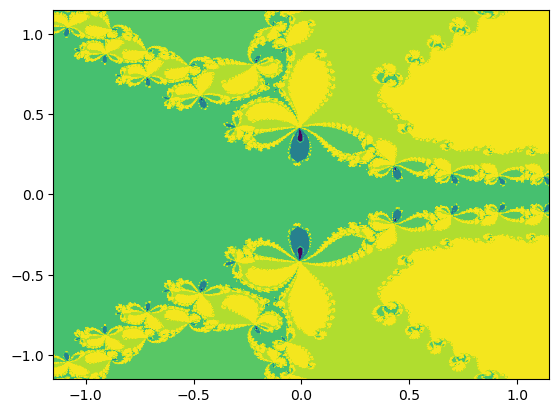

In [3]:
N=2**10
lim=1.15
limj=1.15j

x=np.linspace(-lim,lim,N,dtype=complex)
xj=np.linspace(-limj,limj,N,dtype=complex)
xx,yy=np.meshgrid(x,xj)
X=xx+yy

# coef=np.array([1]*15)
coef=np.array(np.random.rand(10))
Z=np.copy(X)
# Z_cpu=np.copy(X)

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(Z.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(Z.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
get_grid_cuda[blockspergrid, threadsperblock](Z,coef,len(coef))
print("Time taken:",time.time() - start)

# Z_cpu=get_grid(Z_cpu)

plt.contourf(X.real,X.imag,Z,levels=30)
plt.show()
plt.close()




roundOff=1
minima=np.unique(Z.round(roundOff))
print(coef)
print(minima)
print(len(minima))

Img=np.zeros((Z.shape[0],Z.shape[1],3)).astype(np.uint8)
# cmap = matplotlib.cm.get_cmap('viridis')
cmap = matplotlib.cm.get_cmap('inferno')

for i in  range(len(minima)):
    # indx=np.argwhere(Val.round(3)==minima[i])
    indx=np.argwhere(np.flip(Z,0).round(roundOff)==minima[i])
    rgba = cmap(i/(len(minima)-1))
    Img[indx[:,0],indx[:,1],:]=np.array(rgba[:-1])*255
    # print(minima[i].real,minima[i].imag)

for i in  range(len(minima)):   
    print(int((minima[i].real+lim)*N),int((minima[i].imag+abs(limj))*N))
    x,y=int((minima[i].real+lim)/(2*lim)*N),int((minima[i].imag+abs(limj))/(2*abs(limj))*N)    
    Img = cv2.circle(Img, (x,y), radius=0, color=(255, 255, 255), thickness=-1)

Img = cv2.circle(Img, (N//2,N//2), radius=0, color=(255, 255, 255), thickness=-1)

plt.imshow(Img)
# plt.gca().set_aspect('equal')
cv2.imwrite('Fractal.png',cv2.cvtColor(Img, cv2.COLOR_RGB2BGR))
plt.show()
# plt.close()



# plt.contourf(X.real,X.imag,Z_cpu,levels=30)
# plt.show()
# plt.close()


In [39]:
@jit(nopython=True)
def NewtonR(x):
    for i in range(100):
        fx=x**3+x**2+x+1
        dfx=3*x**2+2*x+1
        div=fx/dfx
        x=x-div
        if(abs(div)<1e-3):
            break
    return x

In [40]:
@jit(nopython=True, parallel=True)
def get_grid(Z):
    for i in prange(len(Z)):
        for j in prange(len(Z[0])):
            Z[i,j]=NewtonR(Z[i,j])
    return Z